In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import warnings
import torch
import numpy as np
warnings.filterwarnings("ignore")

from doclayout_yolo import YOLOv10
from ultralytics import YOLO
from typing import Literal

In [2]:
img = cv2.imread('data/image.png')

In [3]:
def trim_edges_noise(
    img: np.ndarray,
    window_size: int = 10,
    max_frac: float = 0.1,
    color_var_thresh: float = 15.0,
    color_mean_diff_thresh: float = 25.0
) -> np.ndarray:
    """
    Trim noisy/colorful regions from all 4 edges using sliding window comparison.

    Args:
        img: RGB or grayscale image (H, W, C) or (H, W).
        window_size: pixel height/width of sliding window.
        max_frac: max fraction (0–1) of height/width to scan inward.
        color_var_thresh: std threshold to call region "noisy".
        color_mean_diff_thresh: mean color difference threshold to detect boundary.

    Returns:
        Cropped image.
    """
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    h, w, _ = img.shape

    top, bottom = 0, h
    left, right = 0, w

    # --- Top ---
    max_y = int(h * max_frac)
    for y in range(window_size, max_y):
        upper = img[y - window_size:y, :]
        lower = img[y:y + window_size, :]

        if is_noisy_border(upper, lower, color_var_thresh, color_mean_diff_thresh):
            top = y
            break

    # --- Bottom ---
    for y in range(h - window_size, h - int(h * max_frac), -1):
        upper = img[y - window_size:y, :]
        lower = img[y:y + window_size, :]

        if is_noisy_border(upper, lower, color_var_thresh, color_mean_diff_thresh):
            bottom = y
            break

    # --- Left ---
    max_x = int(w * max_frac)
    for x in range(window_size, max_x):
        left_block = img[:, x - window_size:x]
        right_block = img[:, x:x + window_size]

        if is_noisy_border(left_block, right_block, color_var_thresh, color_mean_diff_thresh):
            left = x
            break

    # --- Right ---
    for x in range(w - window_size, w - int(w * max_frac), -1):
        left_block = img[:, x - window_size:x]
        right_block = img[:, x:x + window_size]

        if is_noisy_border(left_block, right_block, color_var_thresh, color_mean_diff_thresh):
            right = x
            break

    return img[top:bottom, left:right]


def is_noisy_border(
    upper: np.ndarray,
    lower: np.ndarray,
    var_thresh: float,
    diff_thresh: float
) -> bool:
    """
    Determine whether there's a clear border between two adjacent windows.

    Args:
        upper, lower: image regions to compare.
        var_thresh: threshold for color std (noise).
        diff_thresh: threshold for color mean difference.

    Returns:
        True if noisy boundary is found.
    """
    upper_mean = upper.mean(axis=(0, 1))
    lower_mean = lower.mean(axis=(0, 1))
    lower_std = lower.std(axis=(0, 1))

    color_diff = np.linalg.norm(lower_mean - upper_mean)
    noise_level = np.mean(lower_std)

    return color_diff > diff_thresh and noise_level > var_thresh

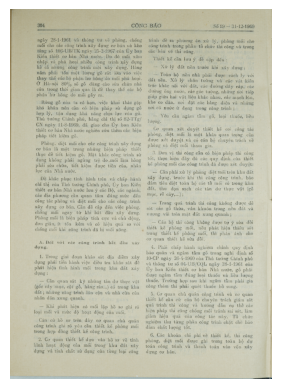

In [4]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cropped = trim_edges_noise(img_rgb, window_size=10, max_frac=0.1, color_var_thresh=15.0, color_mean_diff_thresh=25.0)
plt.imshow(cropped)
plt.axis('off')
plt.show()